# LED Data Analysis Using Tool Functions
## Import the Libraries

In [1]:
import sys,os
import time 
import h5py

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy.optimize import curve_fit
from scipy.stats import norm

sys.path.append('/home/nexus-admin/NEXUS_RF/BackendTools')
import PyMKID_USRP_functions as PUf
import PyMKID_resolution_functions as Prf
import MB_equations as MBe
import MB_analysis as MBa
import TimestreamHelperFunctions as Thf
import OptFilterTools as oft

## Define the MB Parameters

In [2]:
## MB Results come from fitting a temperature scan at a specified RF power
use_nexus_MBvals = False

if use_nexus_MBvals:
    ## As measured in NEXUS
    MB_fit_vals = np.array([4.24216+9.75e-6, 
                            0.177  ,
                            0.0125 ,
                            4.1e7  ]) ## [ F0 [GHz] , Delta [meV] , alpha , Qi0 ]
else:
    ## As measured on Caltech sister device (https://arxiv.org/pdf/2111.08064.pdf)
    MB_fit_vals = np.array([4.24201000, 
                            0.184     ,
                            0.03801   ,
                            4.05538e5 ]) ## [ F0 [GHz] , Delta [meV] , alpha , Qi0 ]
    
## How much attenuation is in the lines before the chip
line_atten_dB = 56.5

## Define the PSD Parameters

In [3]:
## PSD hi and lo frequency limits
chunk_up_to      = 1e1
decimate_down_to = 5e4

## Transient period at front of timestream
blank_fraction = 0.1

## Removal decimation for cleaning (more == better high-F cleaning)
removal_dec    = 10

## Pull the Data Files

In [4]:
datapath = '/data/USRP_Laser_Data'
series   = "20230215_101743"

sum_file, dly_file, vna_file, nse_files, led_files = Thf.GetFiles(series, 
                                                        base_path=datapath,
                                                        sep_noise_laser=True,
                                                        verbose=False)

n_runs   = len(led_files)
for f in nse_files:
    print(f)

/data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0.h5
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0_11.h5
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0_14.h5
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0_2.h5
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0_5.h5
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0_8.h5


## Extract Voltage and Pulse Profile Information

In [5]:
voltages, p_params, charFs, charZs = oft.parse_metadata(sum_file, 
                                                        blank_fraction=blank_fraction, 
                                                        verbose=True)

RF Power at USRP: -25 dBm
Char. freqs:  [[4241.97901  4241.979857 4241.980704]
 [4241.97901  4241.979857 4241.980704]
 [4241.97901  4241.979857 4241.980704]
 [4241.97901  4241.979857 4241.980704]
 [4241.97901  4241.979857 4241.980704]
 [4241.97901  4241.979857 4241.980704]]
Char. S21s:   [[0.13392927+0.06659739j 0.13341133+0.07298083j 0.13270856+0.08030111j]
 [0.13429799+0.06697518j 0.13330332+0.07371326j 0.13196758+0.08167826j]
 [0.1346246 +0.06696931j 0.13358658+0.07367139j 0.13323895+0.08044304j]
 [0.13432564+0.06824386j 0.13380083+0.07443833j 0.1335927 +0.08105339j]
 [0.13312294+0.06672976j 0.13253673+0.07319285j 0.13192562+0.0804867j ]
 [0.13273744+0.06659688j 0.13206492+0.07325275j 0.13212356+0.07980579j]]
Duration: 200.0 sec
Pulse f:  5.0 Hz
Pls wdth: 2.0 us
P  delay: 5.0 ms
Total pulse windows in acq.:  1000.0
Time between pulse arrival:   0.2 sec
Number of windows to look at: 900


/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


## Noise Cleaning and PSDs

Will separate data into  300 chunks to achieve the requested 1.00e+01  Hz low  end of the PSD
Additional decimation by 20 needed to achieve the requested 5.00e+04  Hz high end of the PSD
Will convert to resonator basis!
doing additional decimation
sampling frequency plugged into welch is 50000
pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0.h5 because override=True!
found 14 pulses
chunk length plugged into welch is 5000
chunked data into 300 timestreams
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0_cleaned.h5 because override=True!
number of chunks used to average is 256
Converting to resonator basis!
Fr from fit  [GHz]: 4241.97985697464
Fr min curve [GHz]: 4241.979948819871
Fr from fit  [GHz]: 4241.97985697464
Fr min curve [GHz]: 4241.979948819871
Will s

/home/nexus-admin/NEXUS_RF/BackendTools/PyMKID_resolution_functions.py:433: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_0, axes_0 = plt.subplots(2,num_freqs,sharex=True,sharey='row',figsize=(5*num_freqs,10))


Will separate data into  300 chunks to achieve the requested 1.00e+01  Hz low  end of the PSD
Additional decimation by 20 needed to achieve the requested 5.00e+04  Hz high end of the PSD
Will convert to resonator basis!
doing additional decimation
sampling frequency plugged into welch is 50000
pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0_5.h5 because override=True!
found 4 pulses
chunk length plugged into welch is 5000
chunked data into 300 timestreams
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0_5_cleaned.h5 because override=True!
number of chunks used to average is 267
Converting to resonator basis!
Fr from fit  [GHz]: 4241.97985697464
Fr min curve [GHz]: 4241.979948819871
Fr from fit  [GHz]: 4241.97985697464
Fr min curve [GHz]: 4241.979948819871
Wil

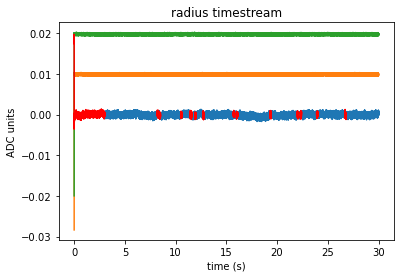

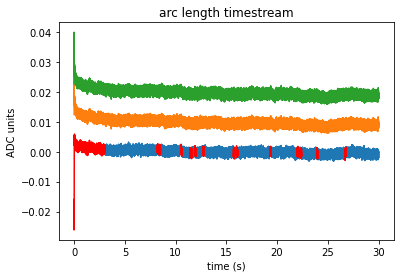

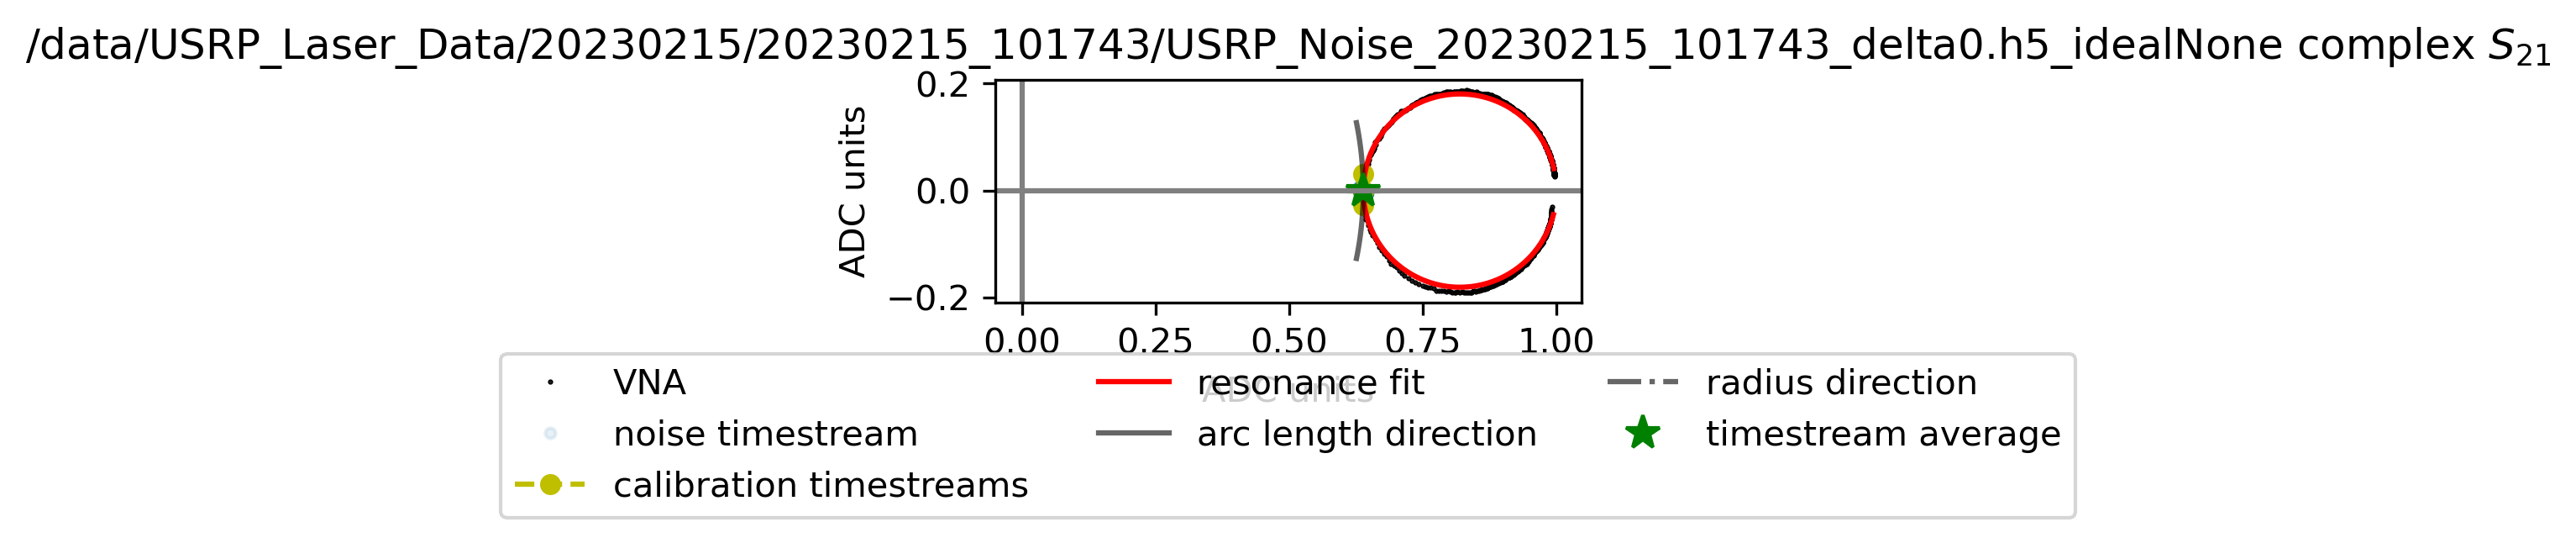

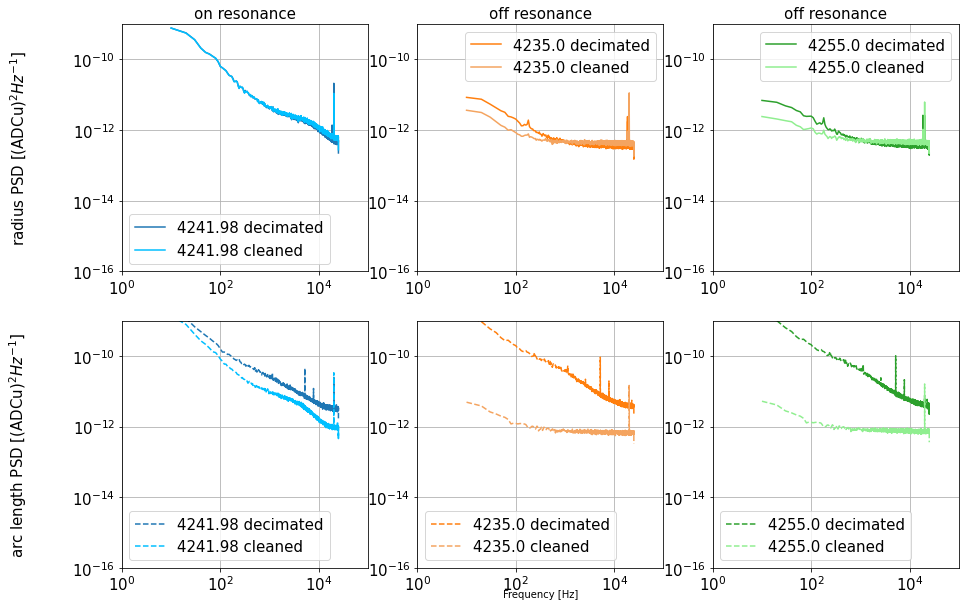

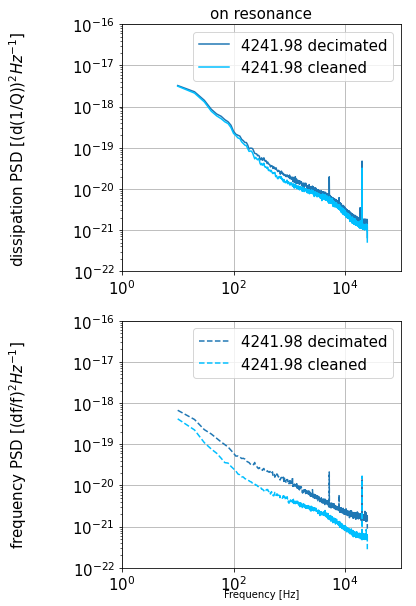

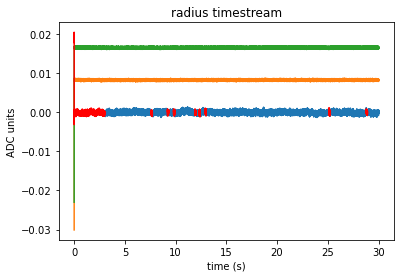

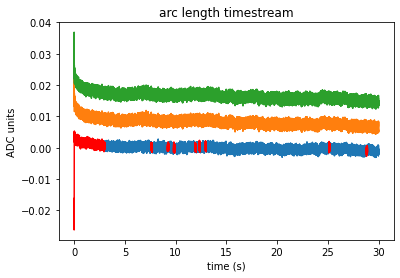

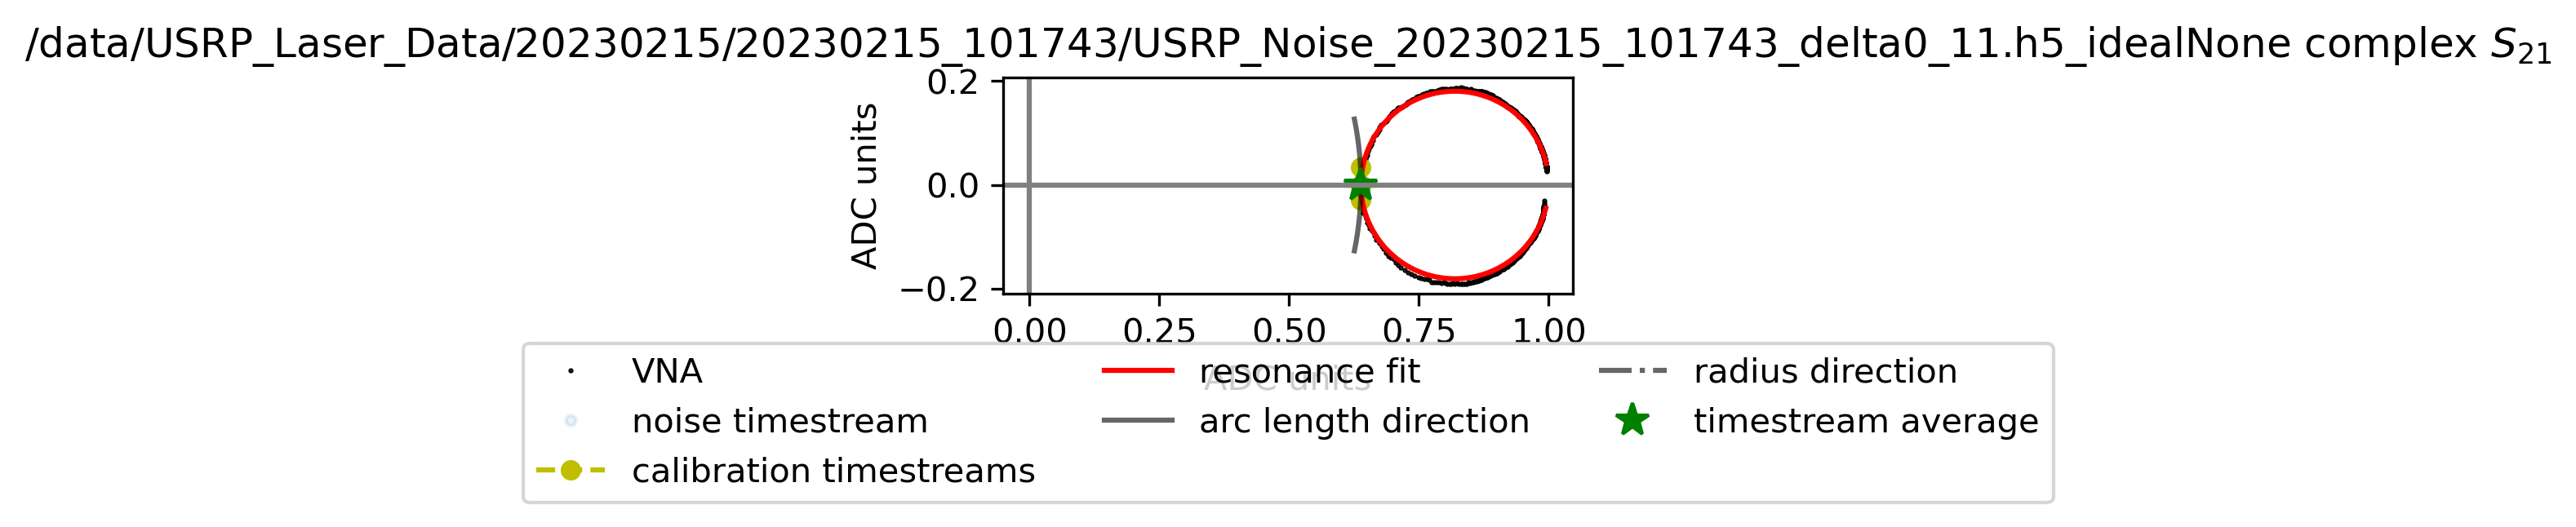

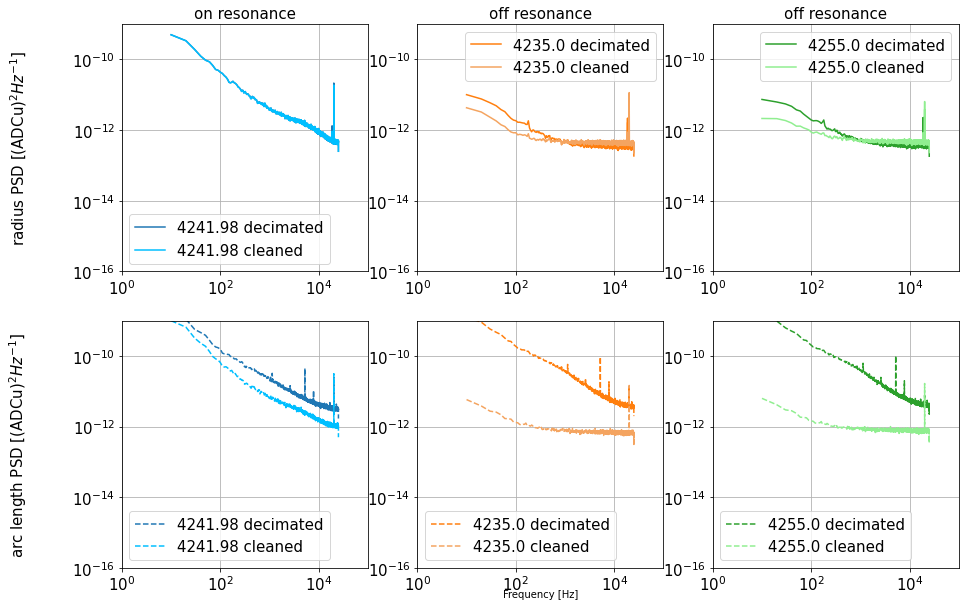

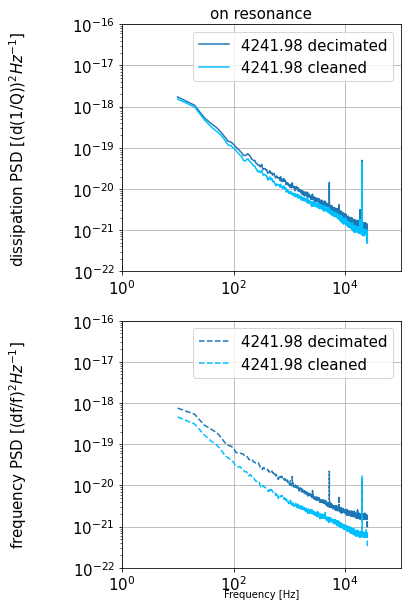

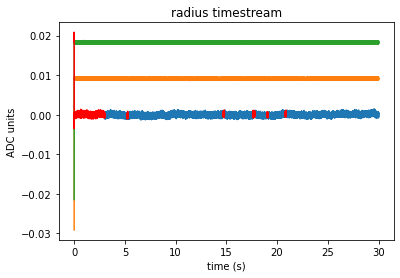

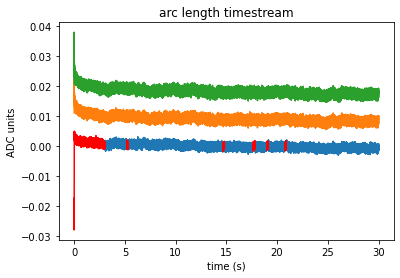

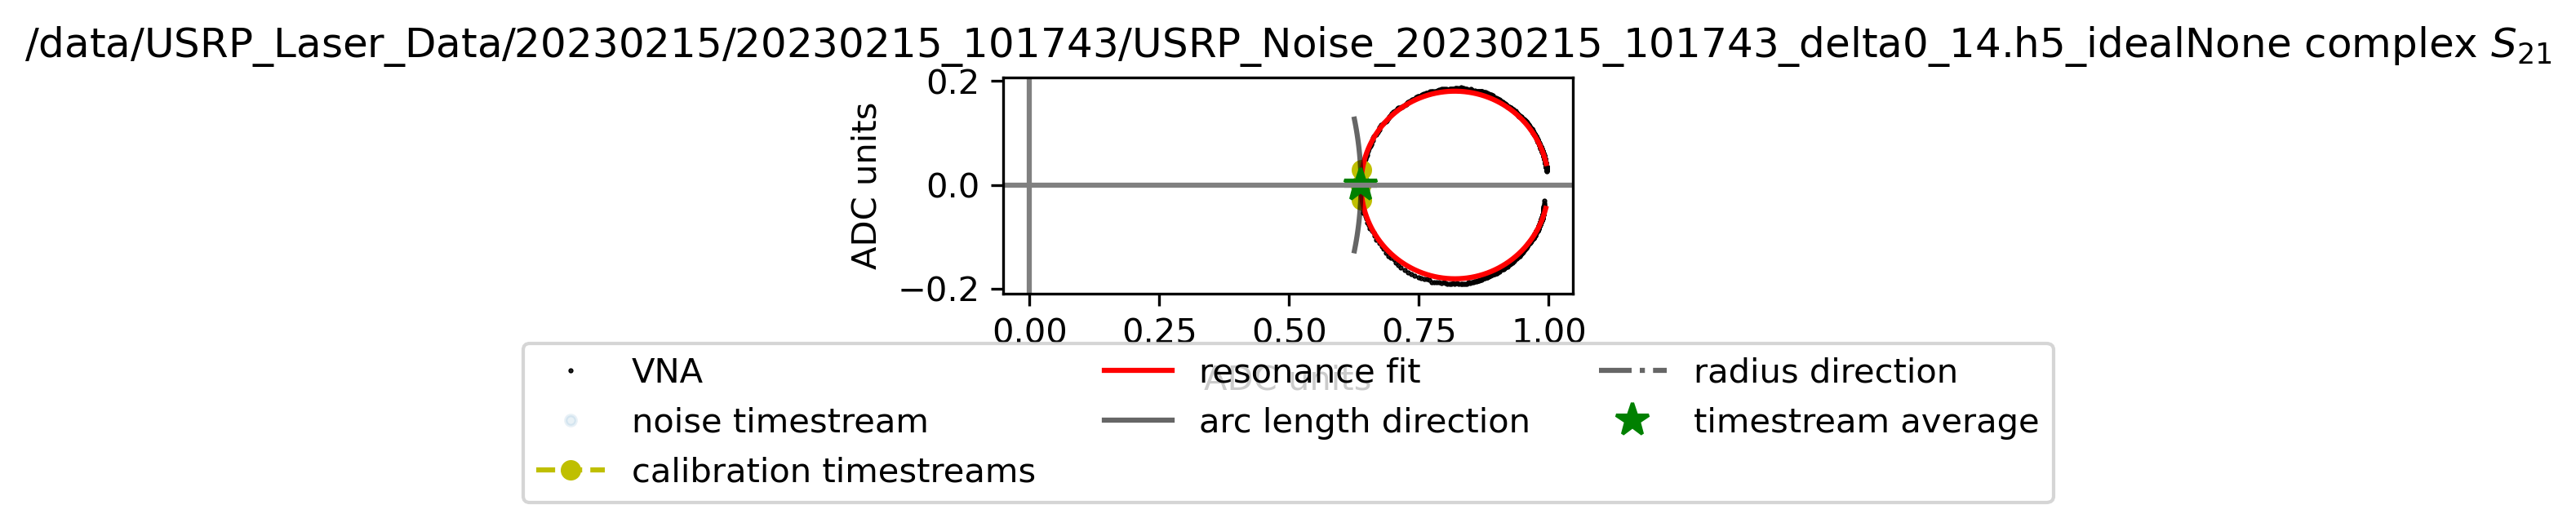

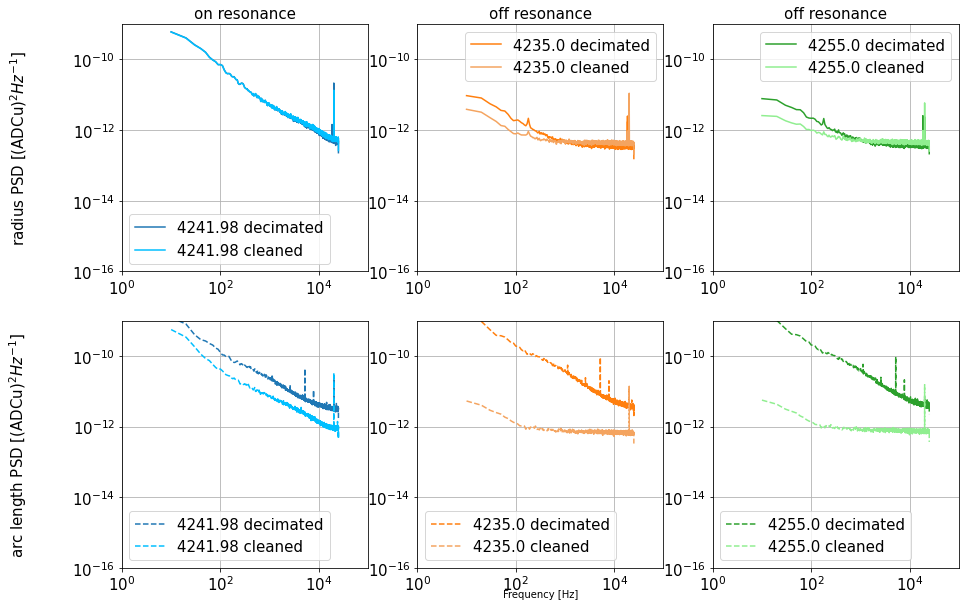

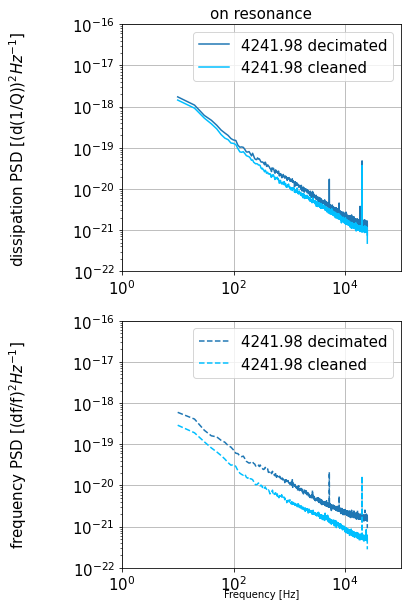

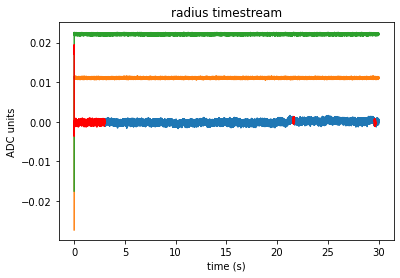

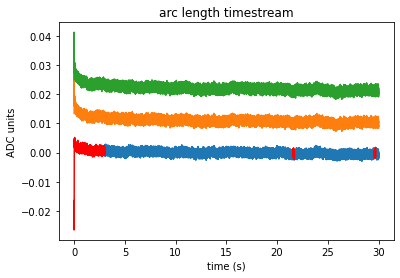

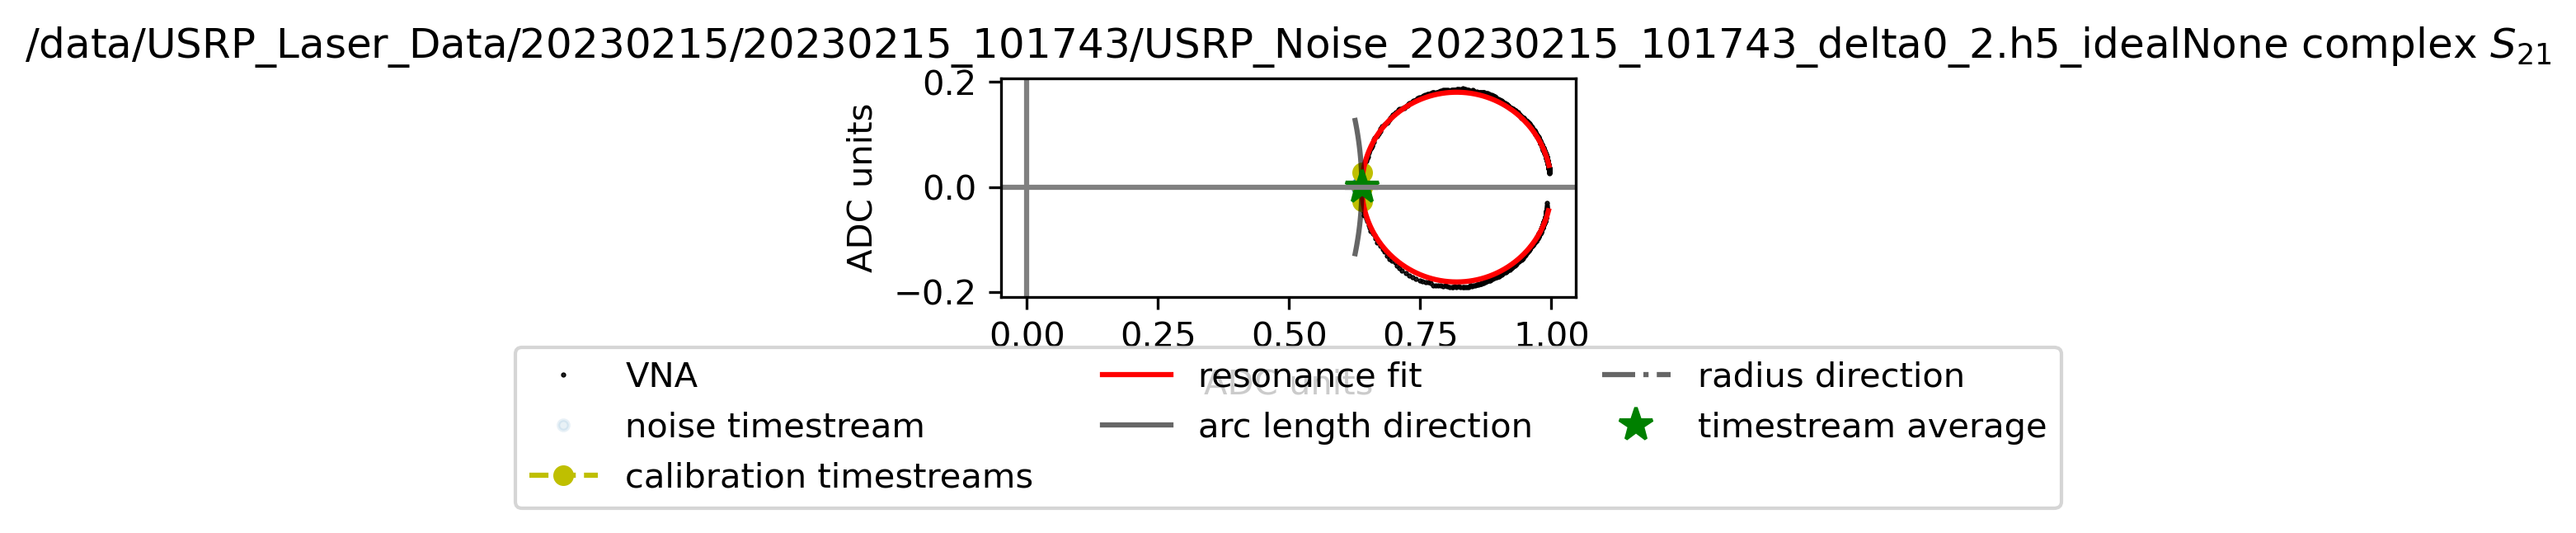

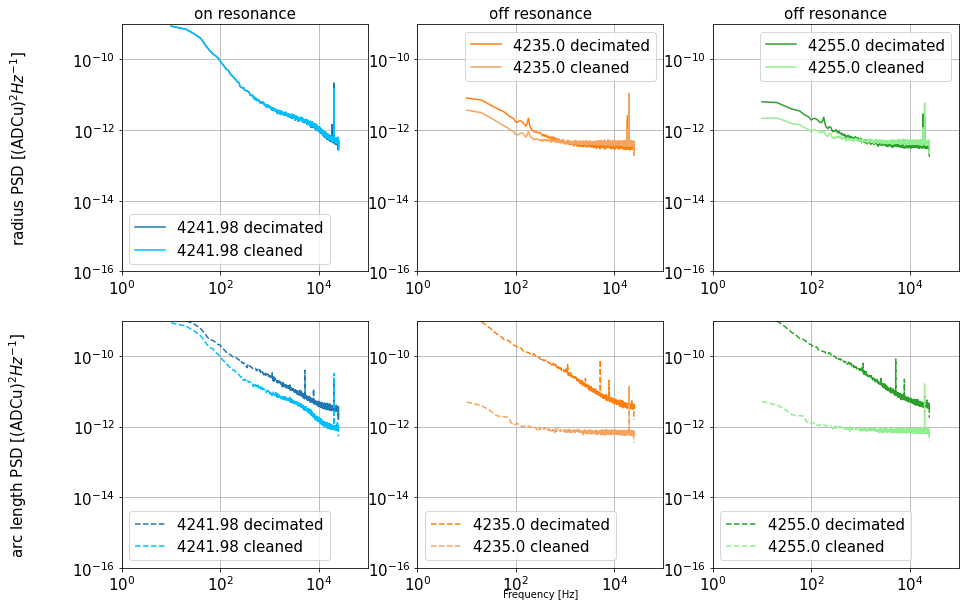

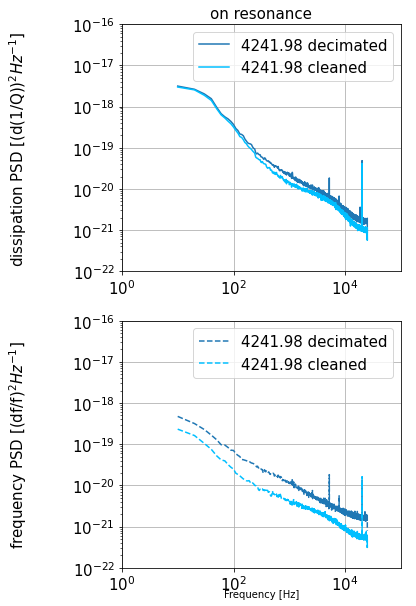

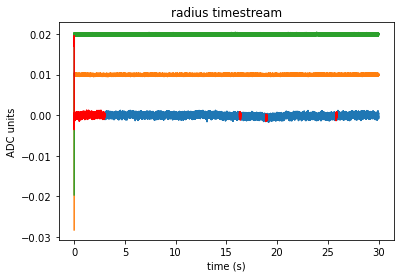

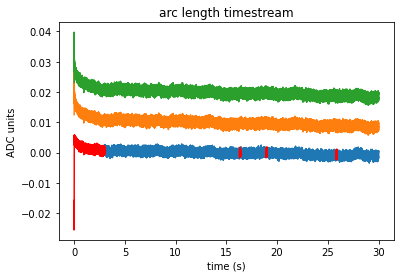

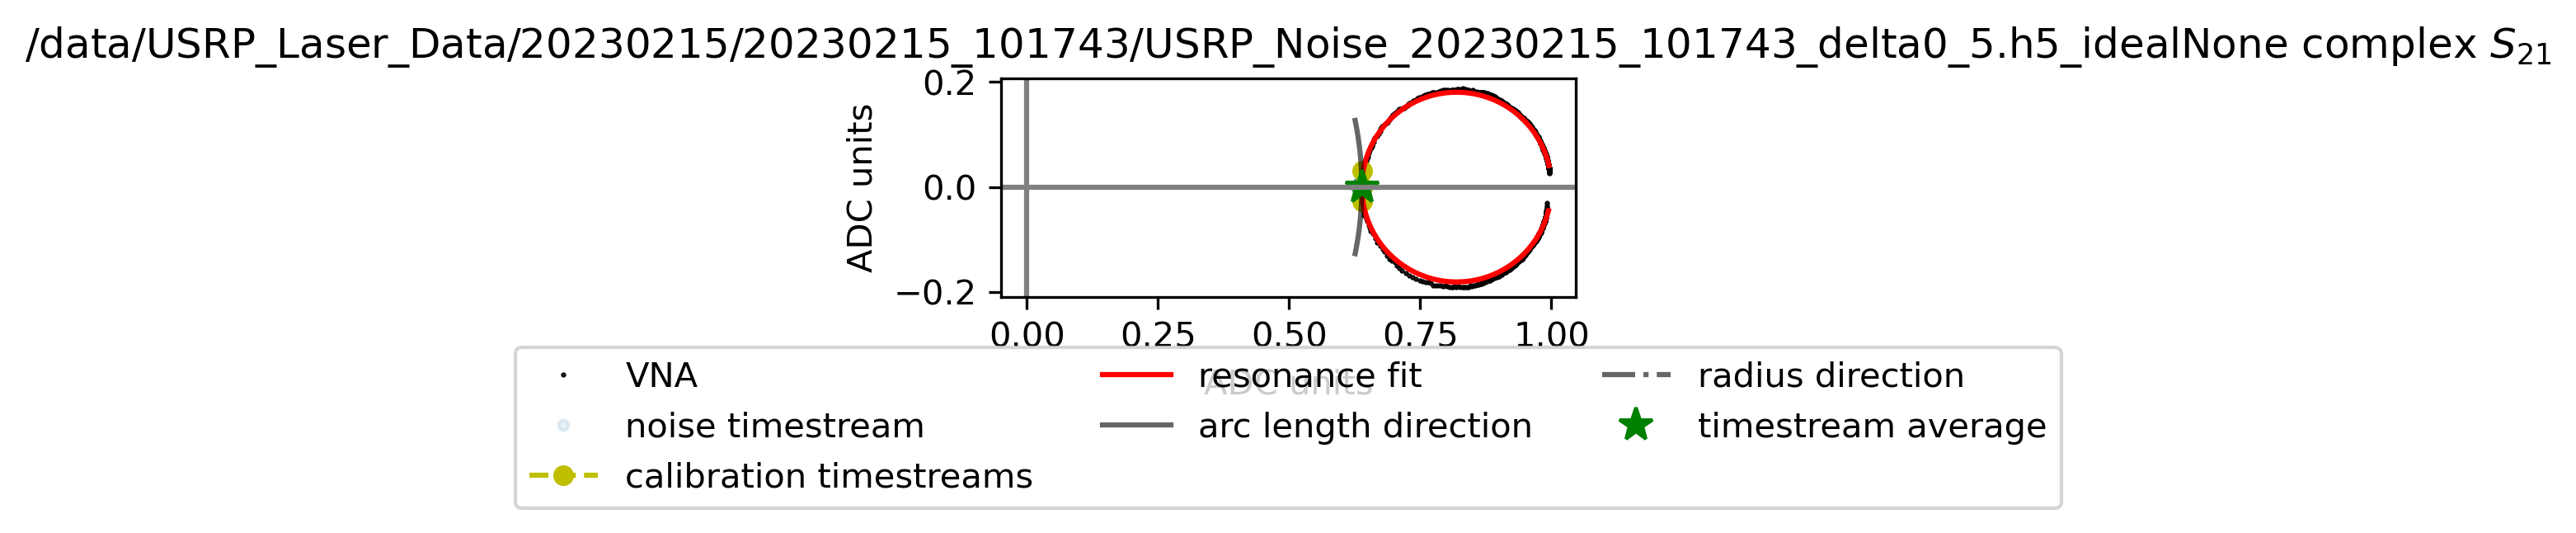

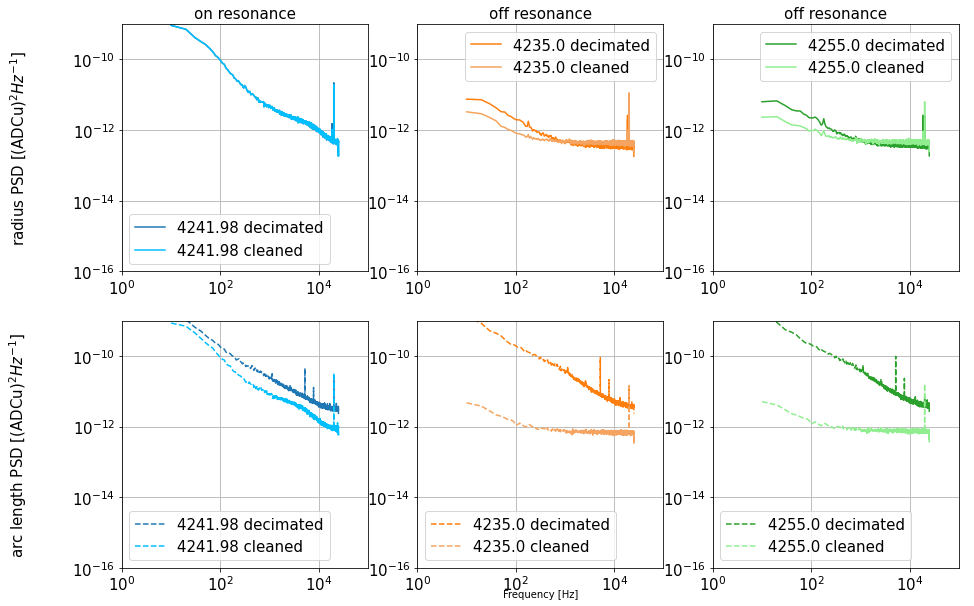

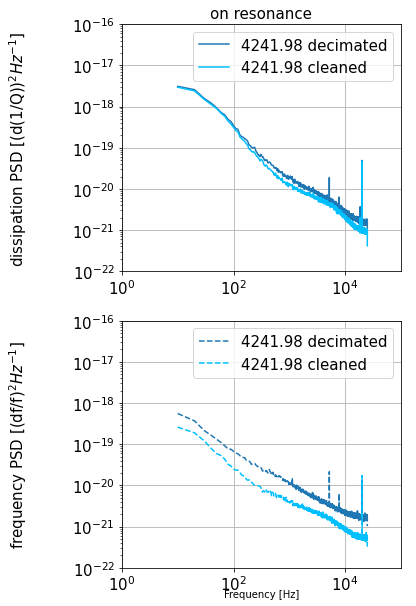

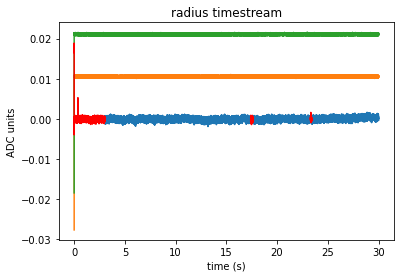

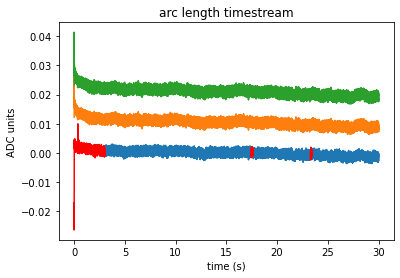

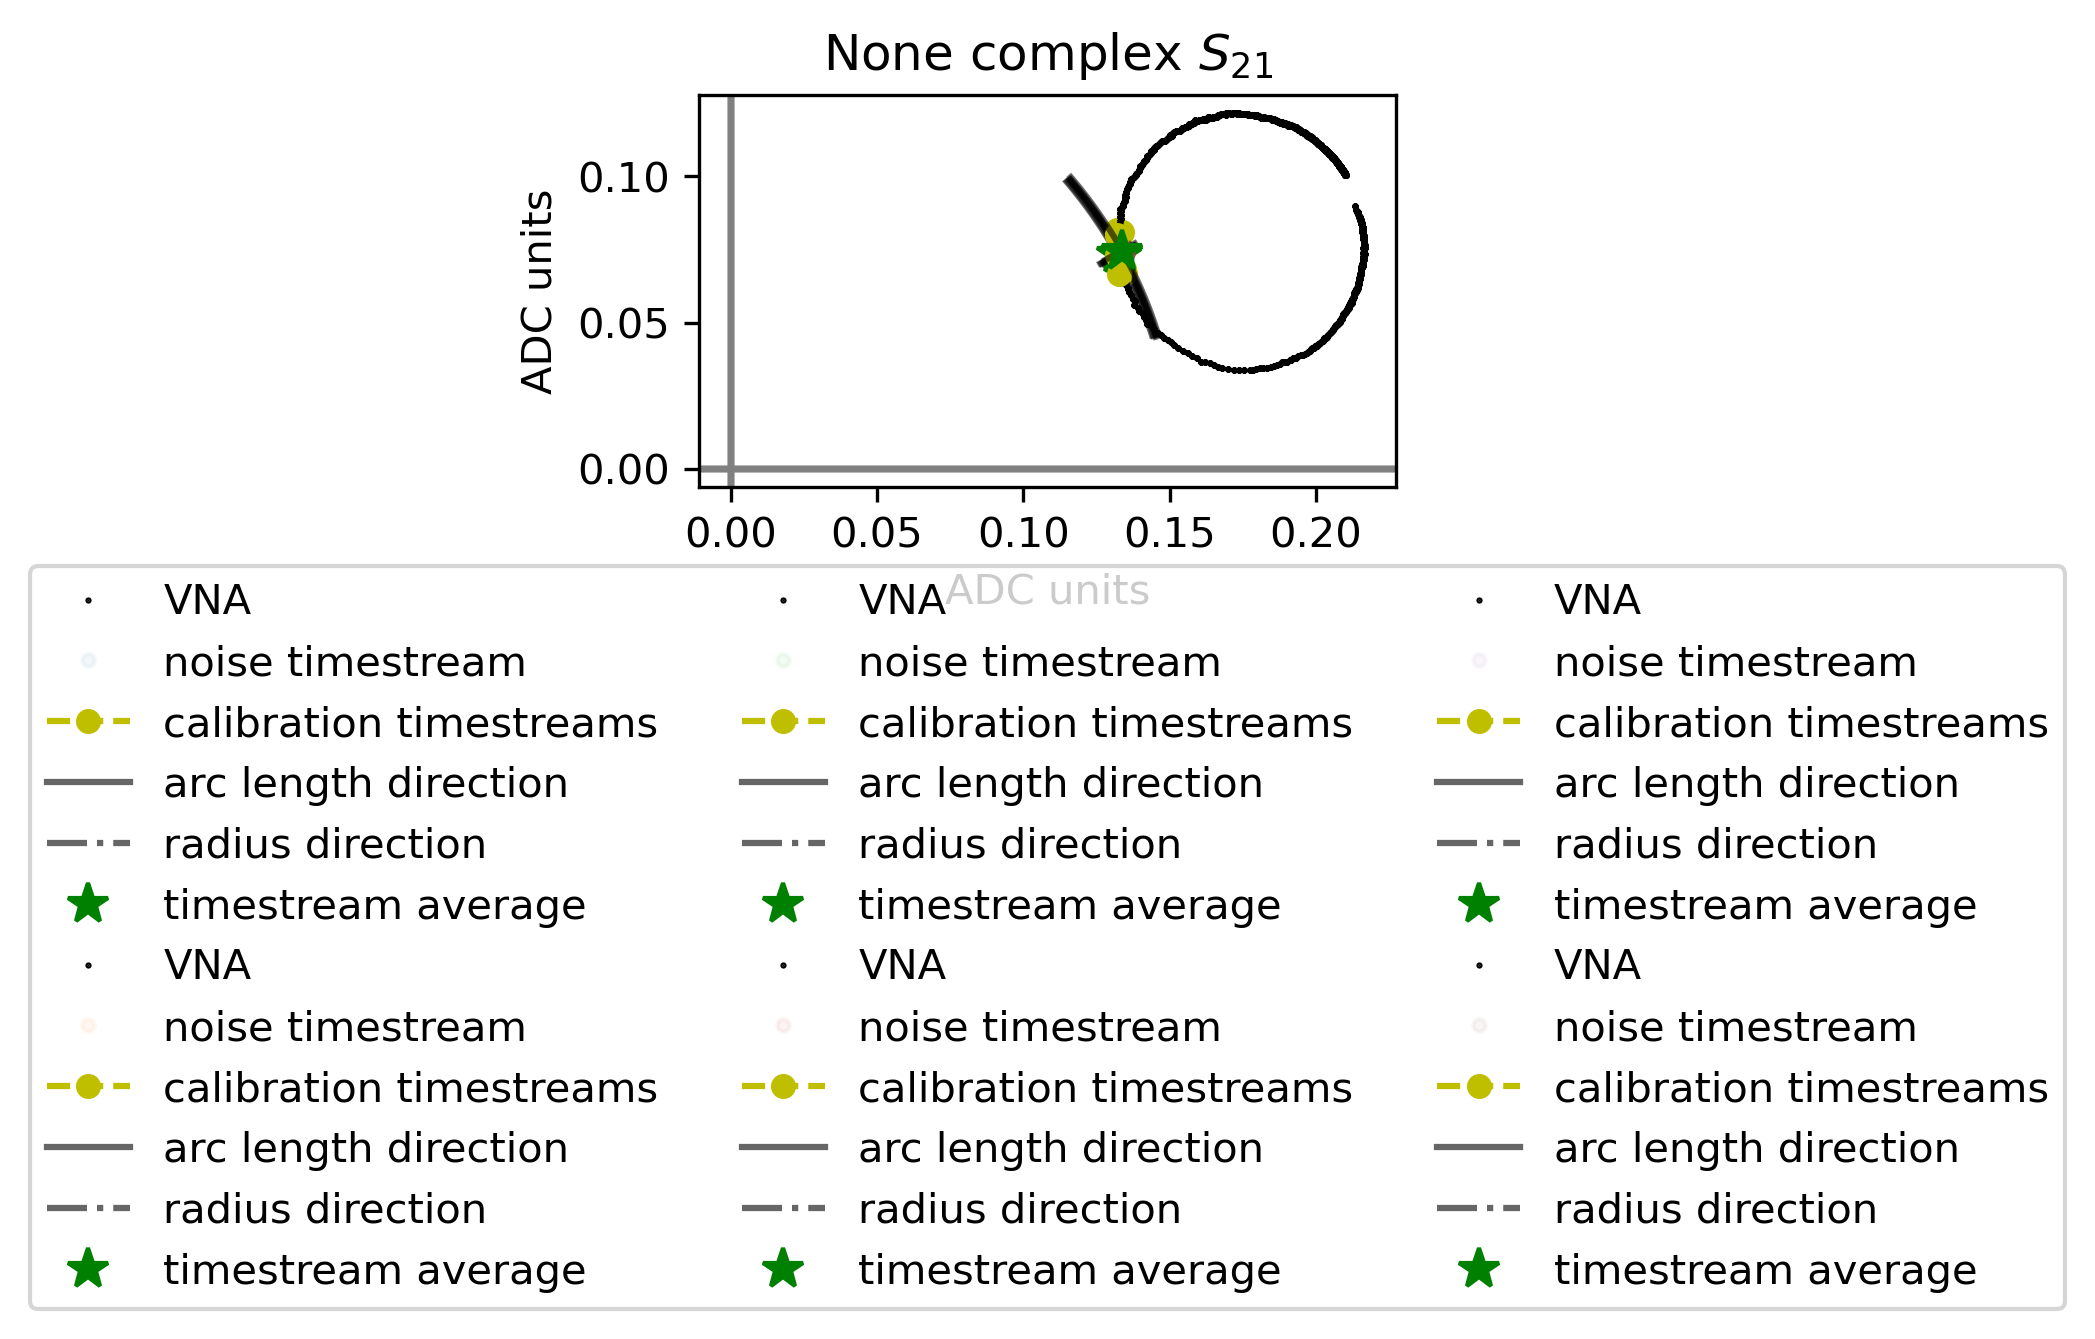

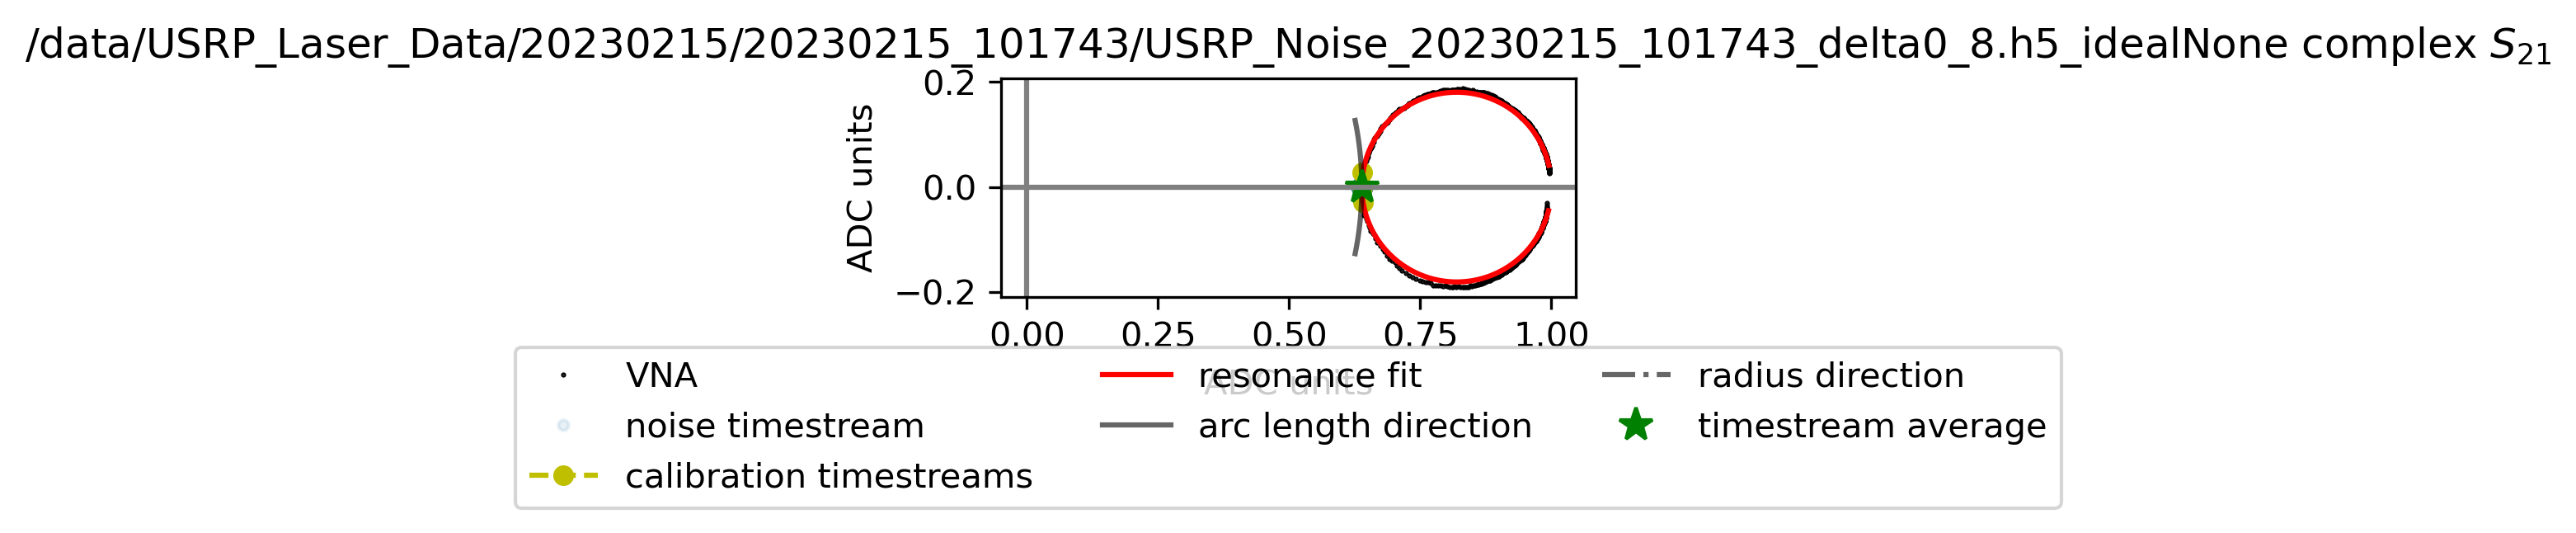

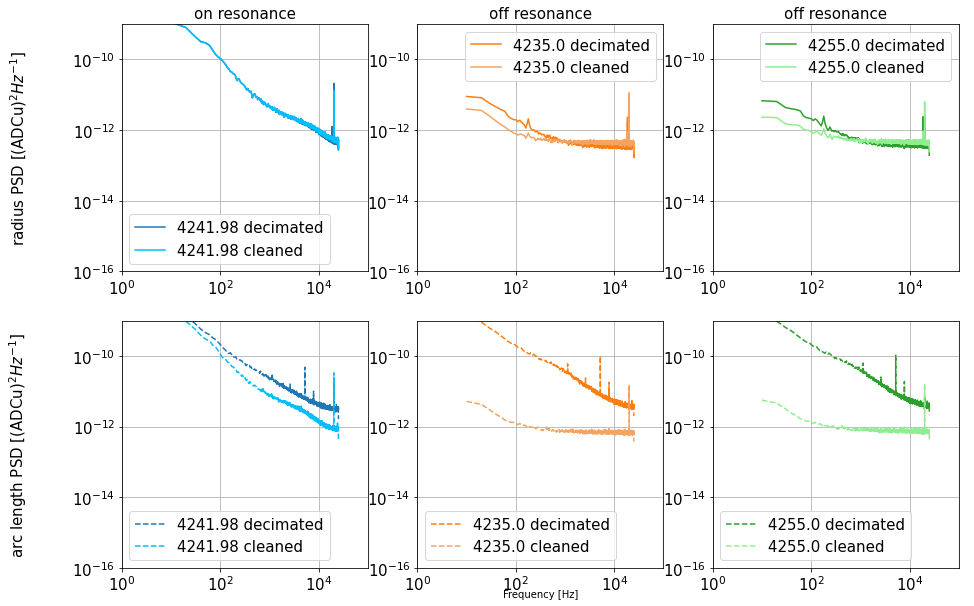

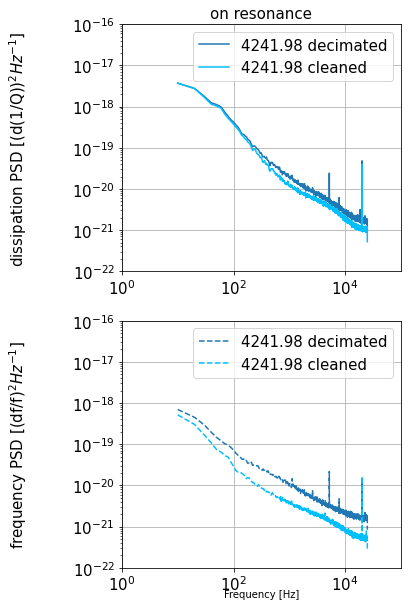

In [6]:
for i in np.arange(len(nse_files)):
    powers, PSDs, res, timestreams = Thf.CleanPSDs(nse_files[i], vna_file, 
        PSD_lo_f=chunk_up_to, 
        PSD_hi_f=decimate_down_to, 
        rem_dec=removal_dec,
        f_transient=blank_fraction, 
        charFs=charFs[i].real, 
        charZs=charZs[i])

## Define the Files To Process

In [7]:
## Look at phase or log-mag
PHASE = True

files_to_skip = 0 ## How many to skip at beginning
files_to_trim = 0 ## How many to cut off at end

LED_files = led_files[files_to_skip:n_runs-files_to_trim]
Voltages  = voltages[files_to_skip:n_runs-files_to_trim]

# LED_files = LED_files[Voltages != 2.50]
# Voltages  = Voltages[ Voltages != 2.50]

for i in np.arange(len(LED_files)):
    print(LED_files[i],":",Voltages[i])

/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.000V_20230215_101743.h5 : 2.0
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.250V_20230215_101743.h5 : 2.25
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.500V_20230215_101743.h5 : 2.5
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.750V_20230215_101743.h5 : 2.75
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.000V_20230215_101743.h5 : 3.0
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.250V_20230215_101743.h5 : 3.25
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.500V_20230215_101743.h5 : 3.5
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.750V_20230215_101743.h5 : 3.75
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_4.000V_20230215_101743.h5 : 4.0
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_4.250V_20230215_101743.h5 : 4.25
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_4.500V_20230215

## Pulse window plotting

In [8]:
mean_dict, sdev_dict, maxv_dict = oft.plot_all_pulse_windows(LED_files, nse_files[0], vna_file, p_params, 
    p1=5, p2=90, decimate_down_to=None, pulse_cln_dec=4,
    PHASE=True, show_plots=False)

plotting pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.000V_20230215_101743.h5
using VNA file:      /data/USRP_Laser_Data/20230215/20230215_101743/USRP_VNA_20230215_101743.h5
using noise file:    /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.250V_20230215_101743.h5
using VNA file:      /data/USRP_Laser_Data/20230215/20230215_101743/USRP_VNA_20230215_101743.h5
using noise file:    /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.500V_20230215_101743.h5
using VNA file:      /data/USRP_Laser_Data/20230215/20230215_101743/USRP_VNA_20230215_101743.h5
using noise file:    /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Las

## Define Cuts

In [9]:
cut_df = oft.define_default_cuts(LED_files, mean_dict, sdev_dict, maxv_dict, PHASE=PHASE, p1=5, p2=90, force_save=False)

# _i = np.argmin(np.abs(Voltages - 2.00))
# cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "mean_min", np.nan)
# cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "mean_max", np.nan)
# cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "sdev_min", np.nan)
# cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "sdev_max", np.nan)
# cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "wfmx_min", np.nan)
# cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "wfmx_max", np.nan)

# if False:
#     oft.save_cut_df(cut_df, LED_files, PHASE=PHASE)

cut_df

H5 cuts file exists, not overwriting...


sdev_min  sdev_max  \
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002324  0.003007   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002331  0.003019   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002330  0.003034   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002332  0.003022   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002341  0.003071   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002346  0.003030   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002320  0.003050   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002305  0.003059   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002311  0.003034   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002270  0.003043   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002292  0.002998   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002279  0.002971   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002265  0.002883   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002277  0.002904   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002274  0.002889   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002274  0.002876   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.002359  0.003084   

                                                    mean_min  mean_max  \
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.487998  0.500396   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.481945  0.492000   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.483356  0.496929   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.484378  0.493500   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.488629  0.496500   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.484012  0.495000   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.482702  0.492500   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.484861  0.495550   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.487251  0.496500   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.492461  0.502000   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.492409  0.507013   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.488296  0.499838   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.489333  0.497000   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.486183  0.497000   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.483313  0.492500   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.485037  0.495000   
/data/USRP_Laser_Data/20230215/20230215_101743/...  0.485817  0.495000   

                                                   wfmx_min wfmx_max  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None    0.525  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None    0.525  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None    0.525  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None     0.53  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None     None  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None     0.65  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None     0.56  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None     None  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None    0.585  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None    0.595  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None    0.605  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None     None  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None     None  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None     None  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None     0.63  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None     None  
/data/USRP_Laser_Data/20230215/20230215_101743/...     None     None

In [10]:
bad_pls_idxs = oft.get_all_bad_pulse_idxs(LED_files, cut_df, mean_dict, sdev_dict, maxv_dict)

/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.000V_20230215_101743.h5 : 250 bad pulses
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.250V_20230215_101743.h5 : 342 bad pulses
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.500V_20230215_101743.h5 : 252 bad pulses
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.750V_20230215_101743.h5 : 367 bad pulses
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.000V_20230215_101743.h5 : 289 bad pulses
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.250V_20230215_101743.h5 : 351 bad pulses
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.500V_20230215_101743.h5 : 363 bad pulses
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.750V_20230215_101743.h5 : 256 bad pulses
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_4.000V_20230215_101743.h5 : 422 bad pulses
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_4.250V_202302

cleaning pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.000V_20230215_101743.h5
using VNA file:      /data/USRP_Laser_Data/20230215/20230215_101743/USRP_VNA_20230215_101743.h5
using noise file:    /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0.h5
saving clean_data to /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.000V_20230215_101743_cleaned.h5 because override=True!
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.000V_20230215_101743.h5
cleaning pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.250V_20230215_101743.h5
using VNA file:      /data/USRP_Laser_Data/20230215/20230215_101743/USRP_VNA_20230215_101743.h5
using noise file:    /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0.h5
saving clean_data to /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.250V_20230215_101743_cleaned.h5 because override=True!
/data/USRP_Laser_Data/

/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_5.500V_20230215_101743.h5
cleaning pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_5.750V_20230215_101743.h5
using VNA file:      /data/USRP_Laser_Data/20230215/20230215_101743/USRP_VNA_20230215_101743.h5
using noise file:    /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0.h5
saving clean_data to /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_5.750V_20230215_101743_cleaned.h5 because override=True!
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_5.750V_20230215_101743.h5
cleaning pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_6.000V_20230215_101743.h5
using VNA file:      /data/USRP_Laser_Data/20230215/20230215_101743/USRP_VNA_20230215_101743.h5
using noise file:    /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0.h5
saving clean_data to /data/USRP_Laser_Data/20230215/20230215_101743/USRP_L

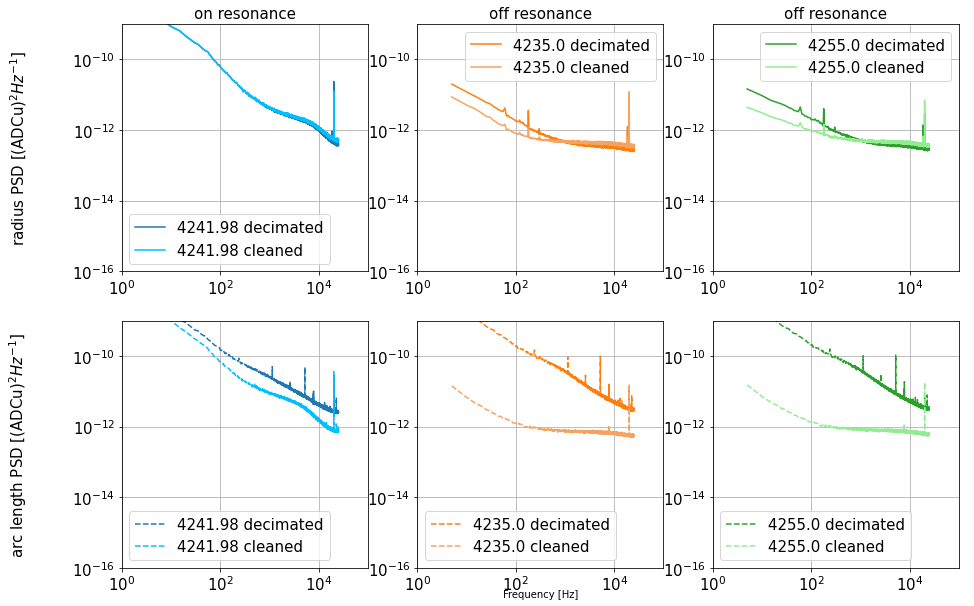

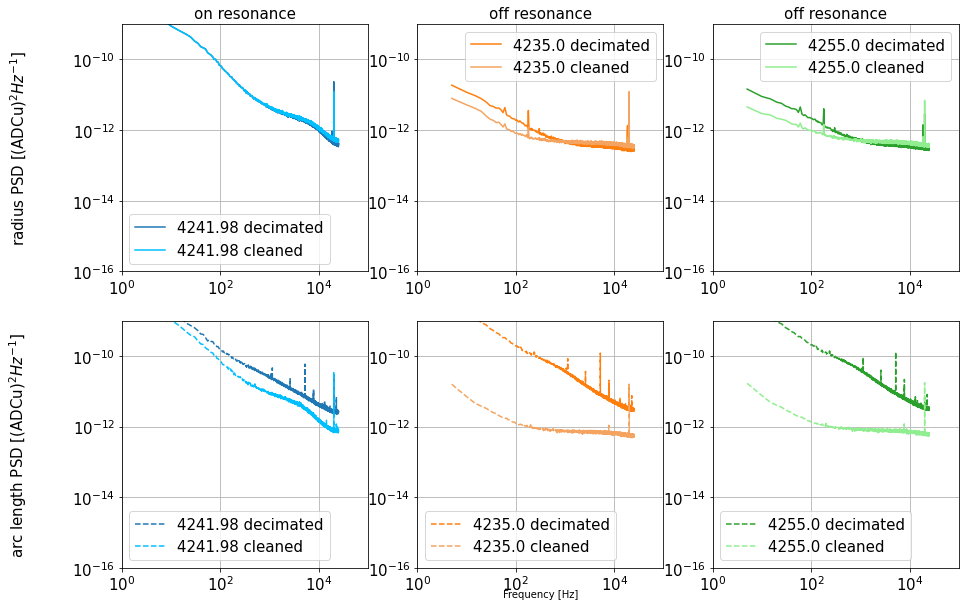

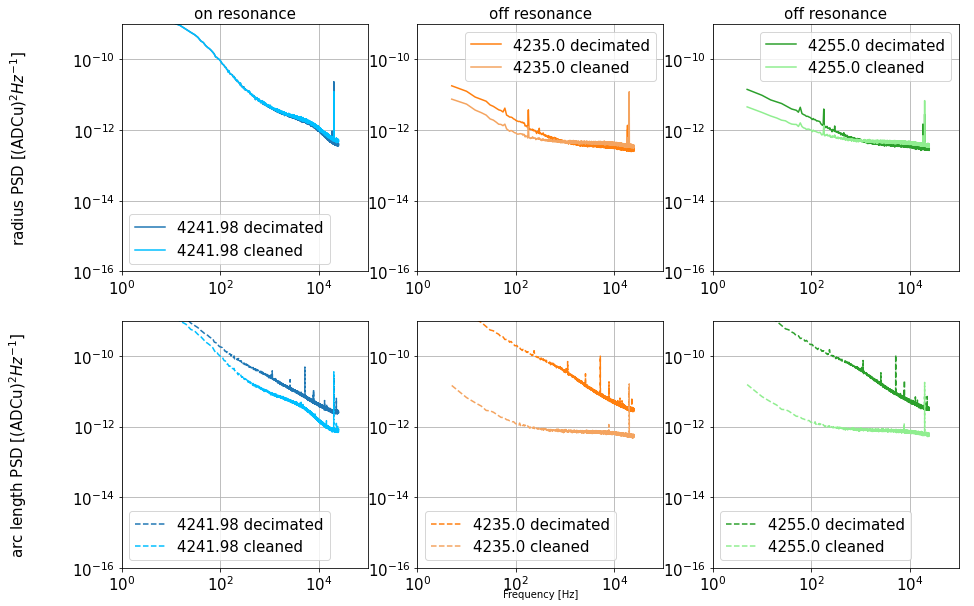

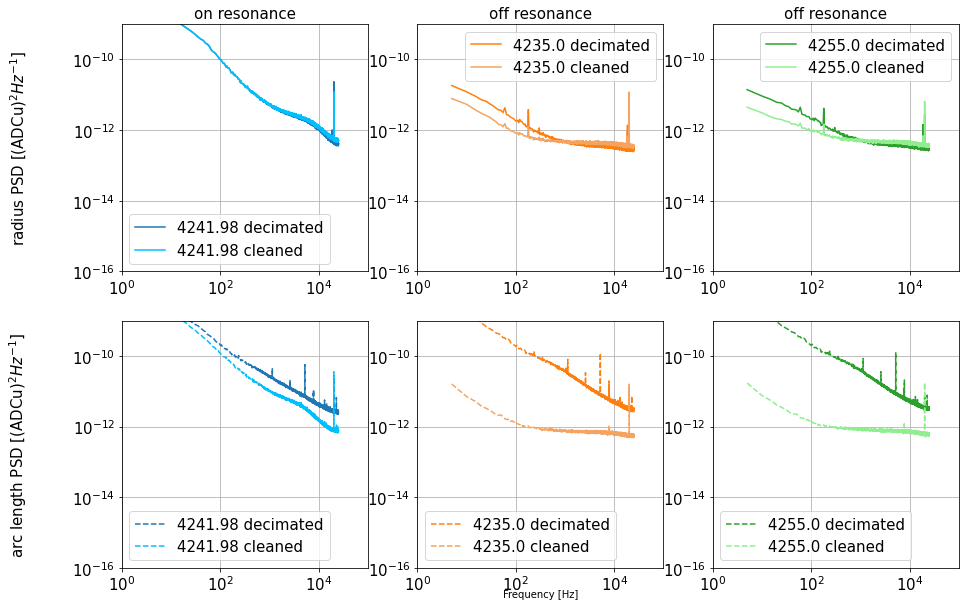

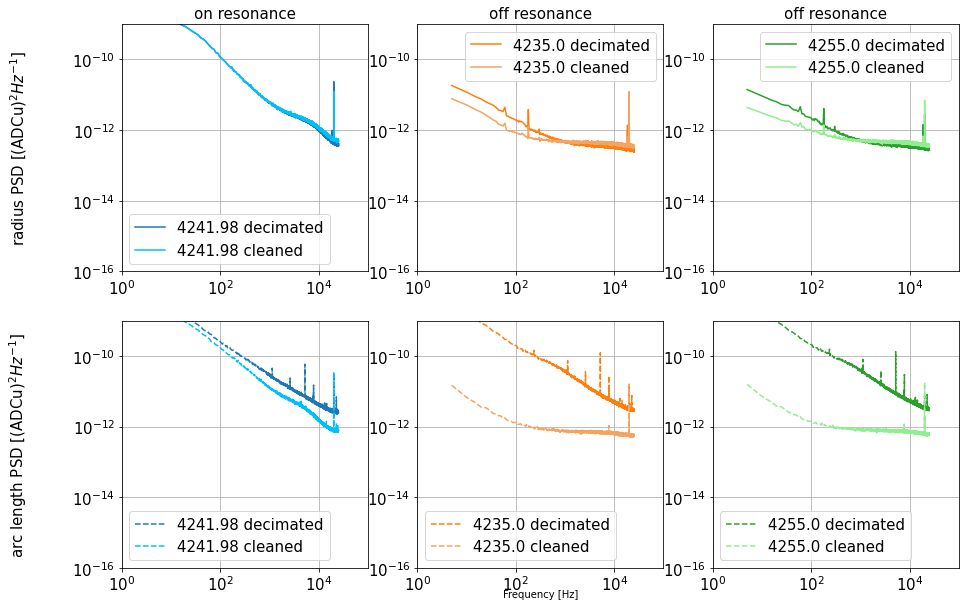

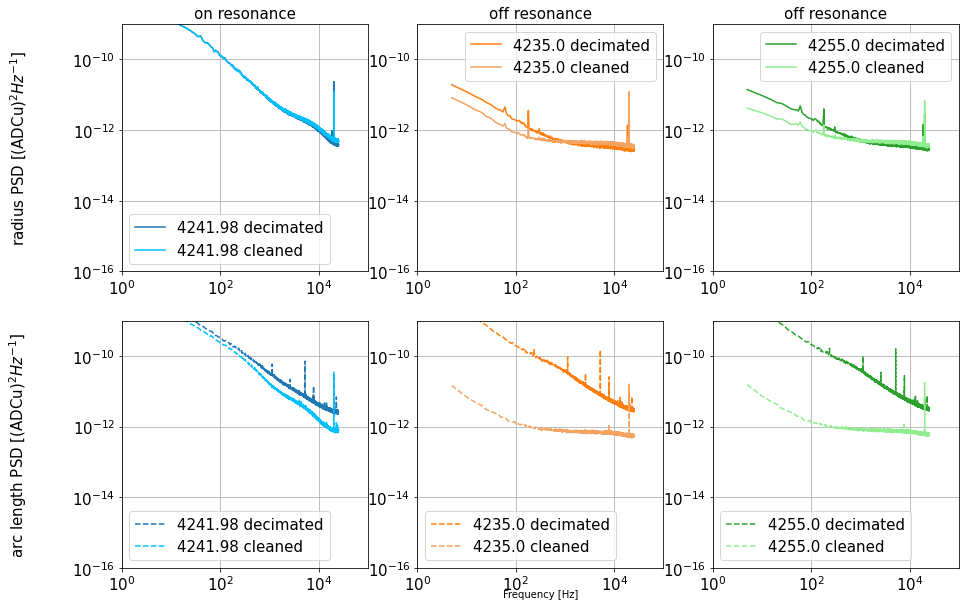

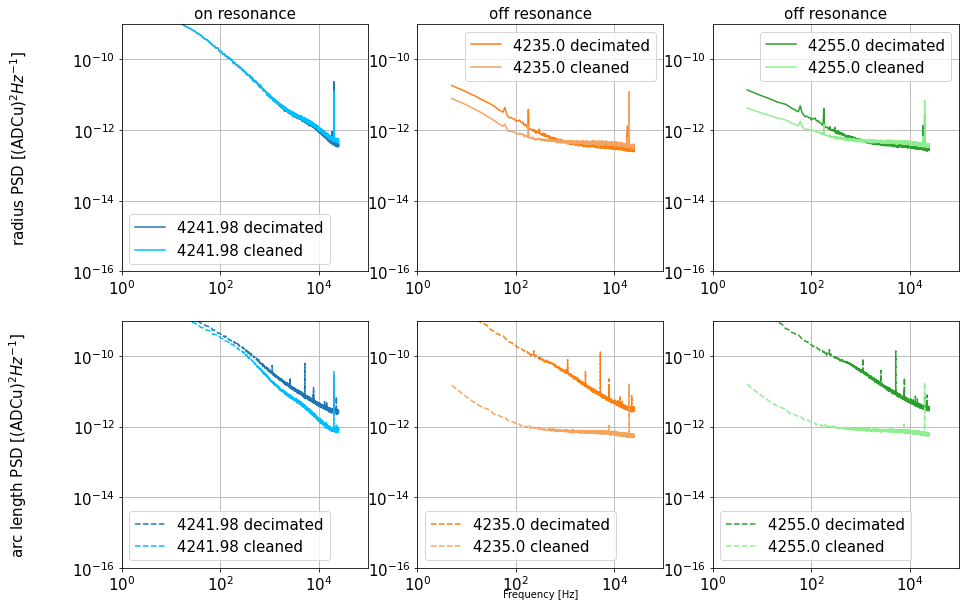

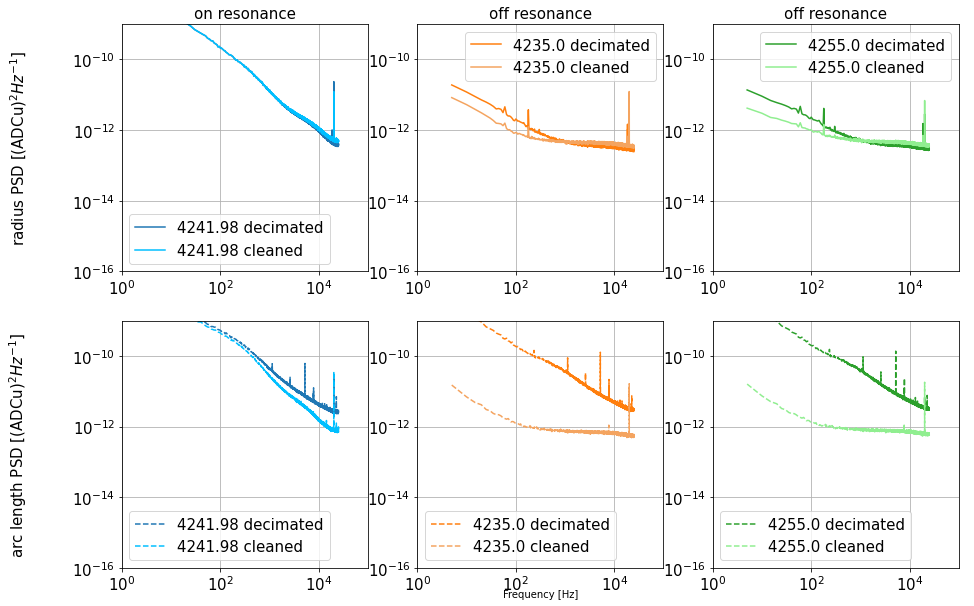

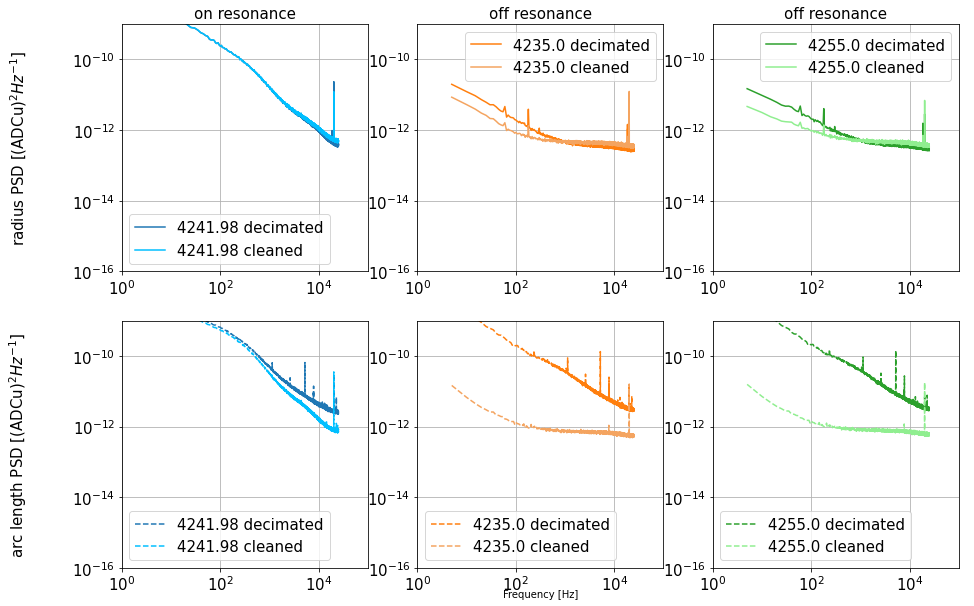

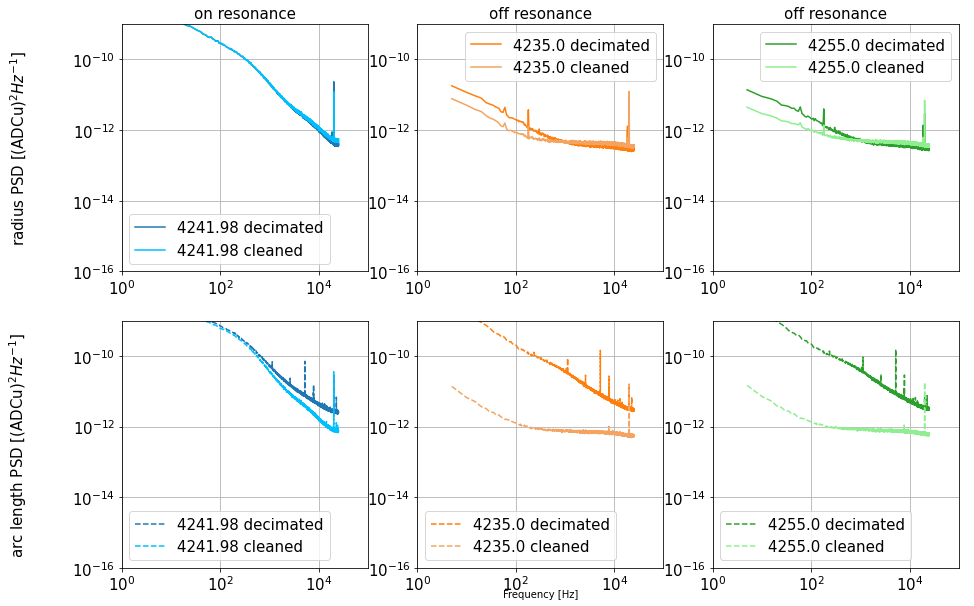

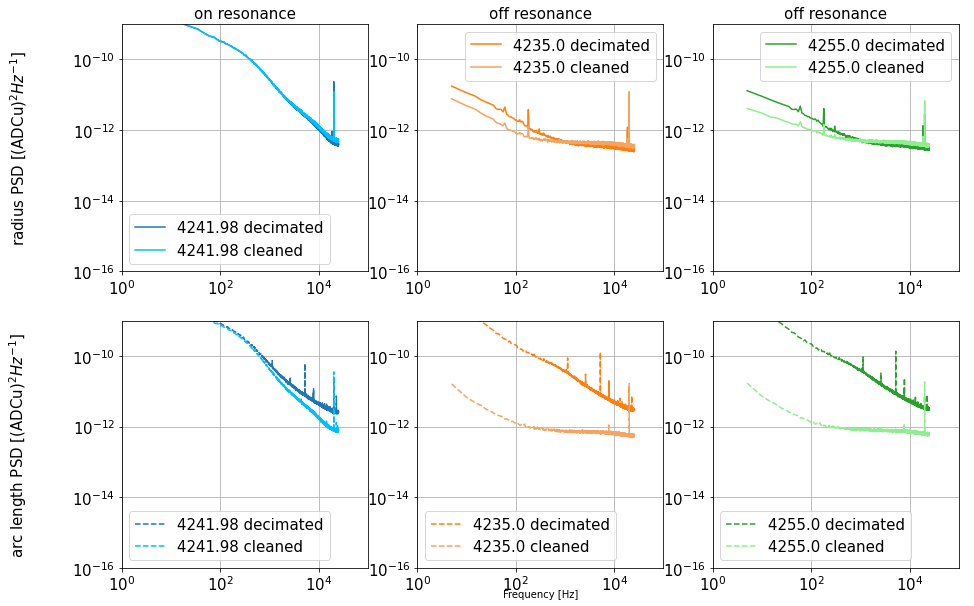

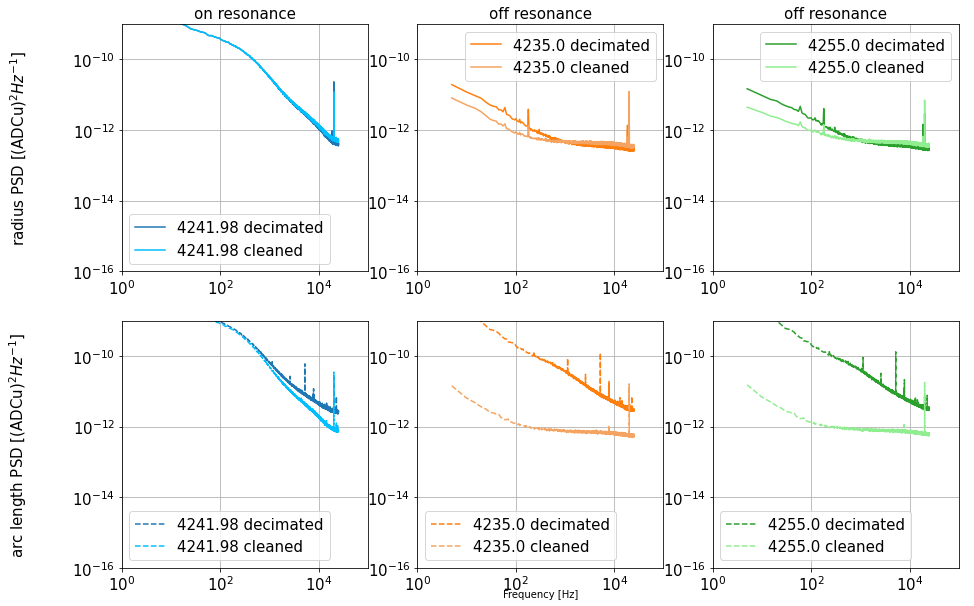

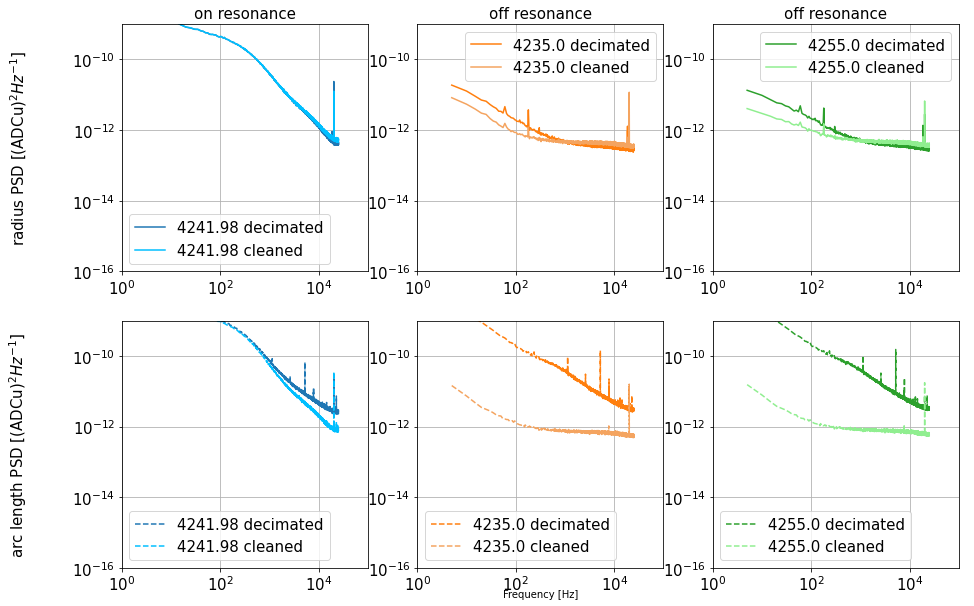

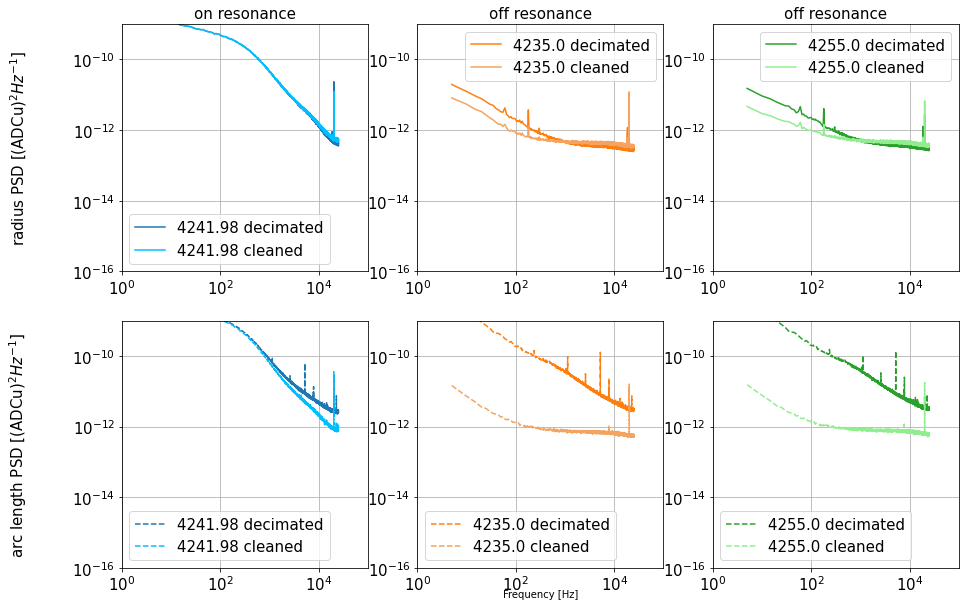

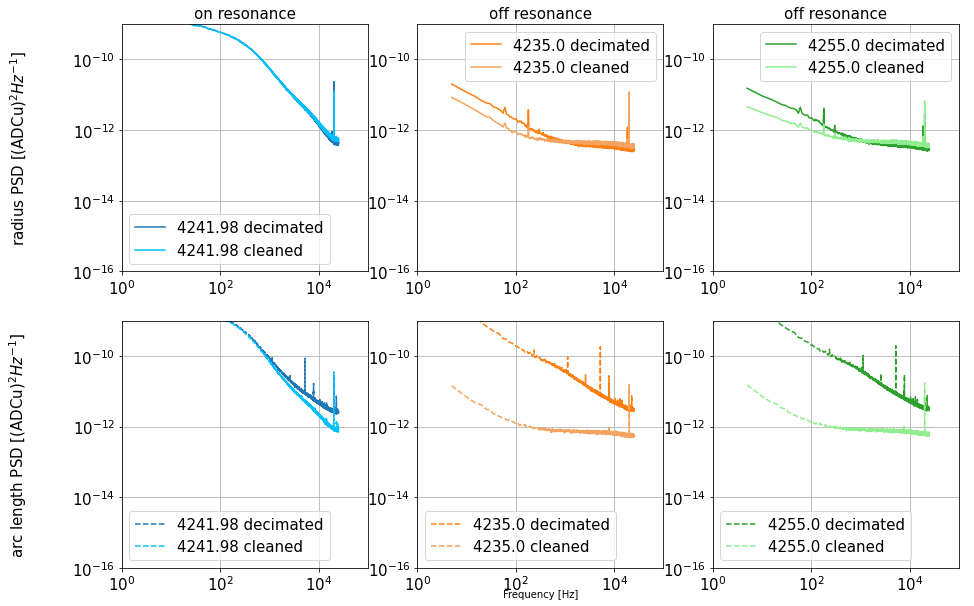

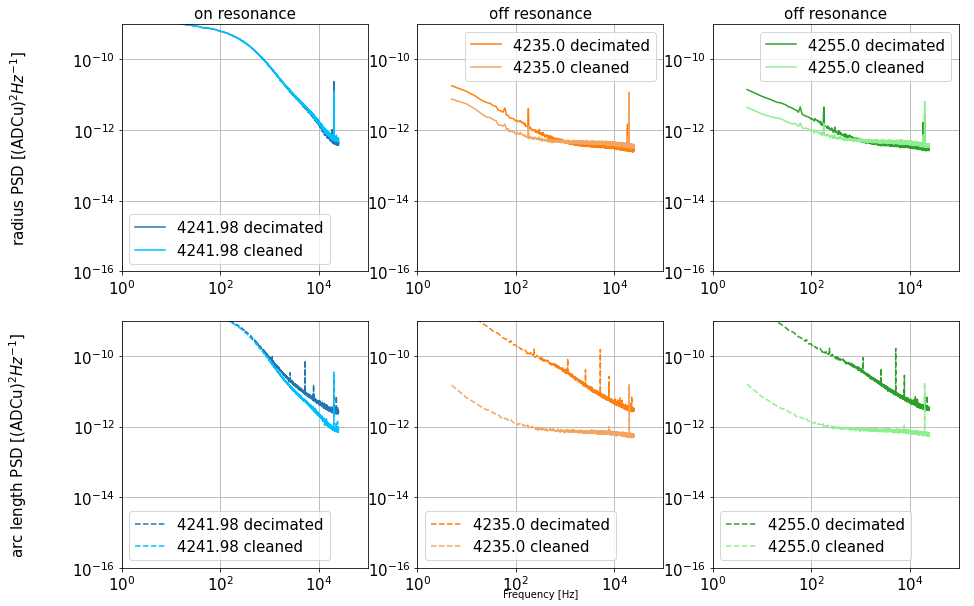

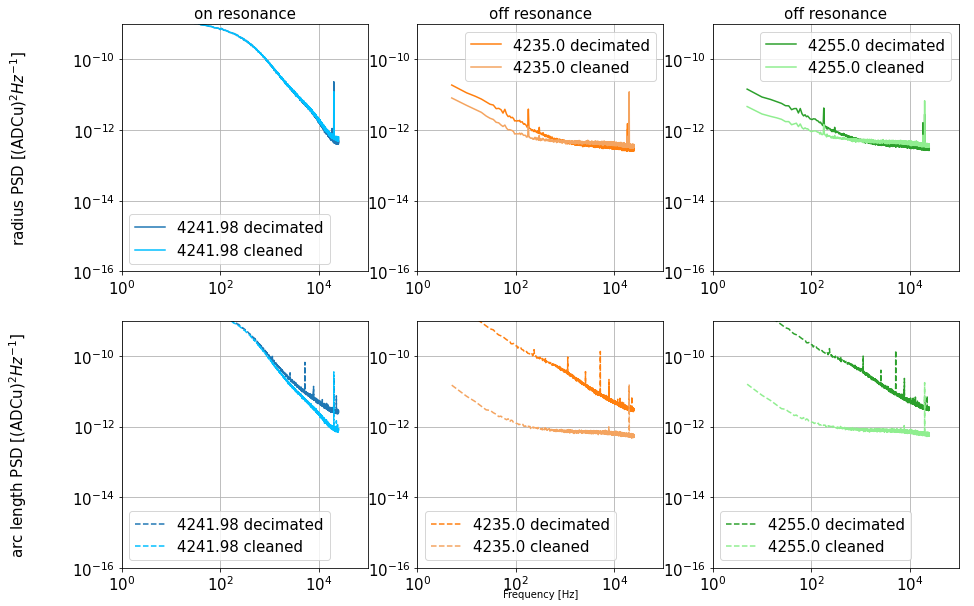

In [11]:
oft.clean_all_pulse_windows(LED_files, nse_files[0], vna_file, p_params, bad_pls_idxs, decimate_down_to=None, pulse_cln_dec=4,PHASE=True)

averaging pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.000V_20230215_101743.h5
Used 650 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.250V_20230215_101743.h5
Used 558 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.500V_20230215_101743.h5
Used 648 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.750V_20230215_101743.h5
Used 533 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.000V_20230215_101743.h5
Used 611 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.250V_20230215_101743.h5
Used 549 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.500V_20230215_101743.h5
Used 537 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230215/20

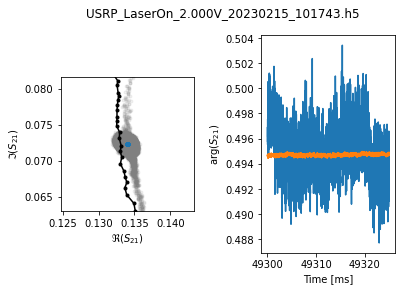

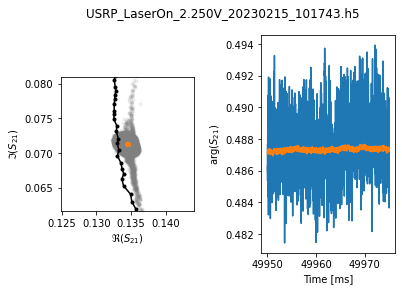

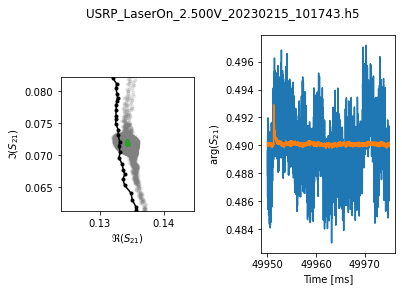

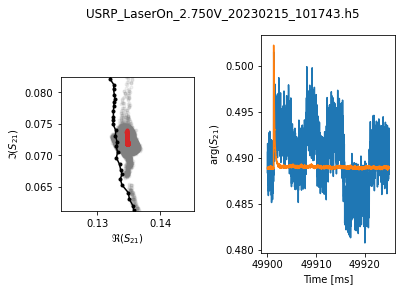

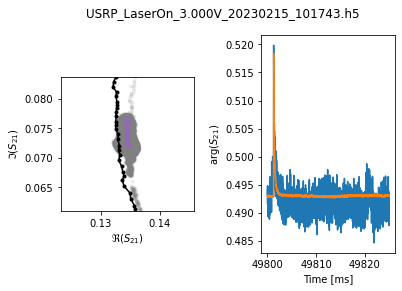

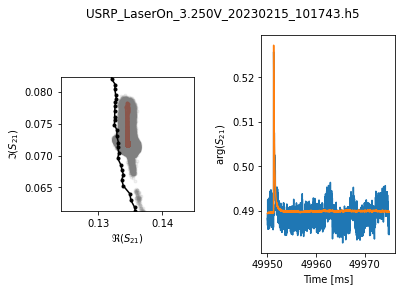

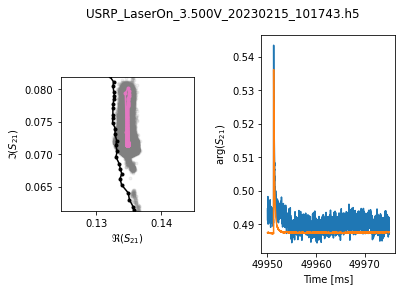

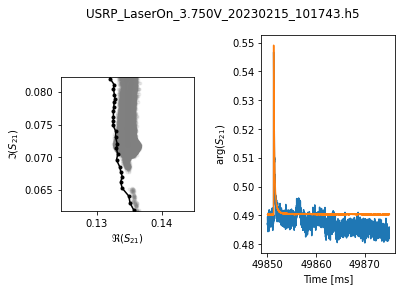

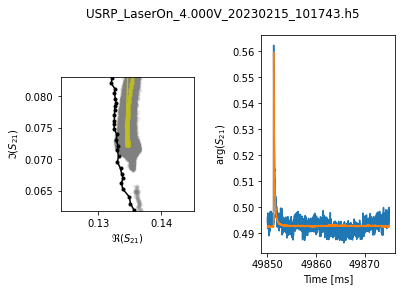

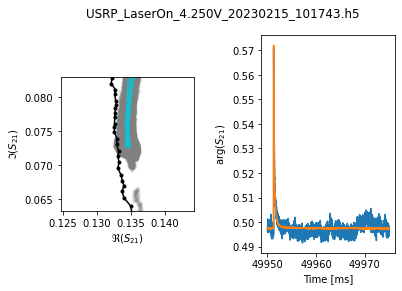

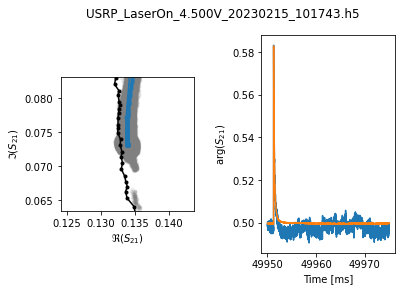

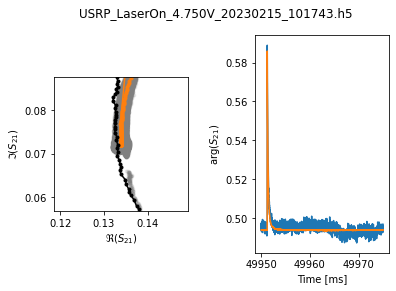

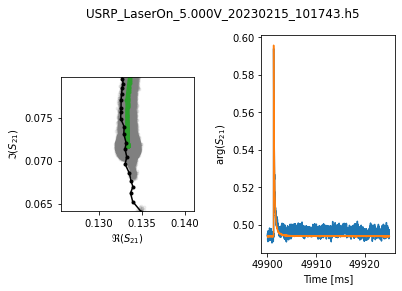

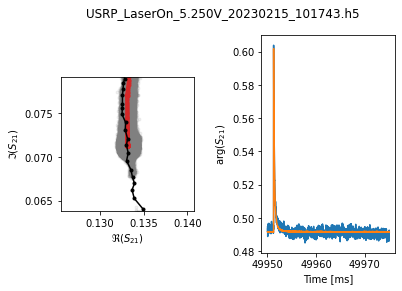

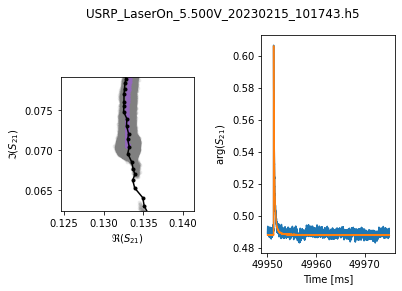

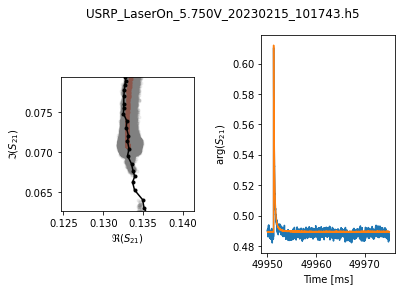

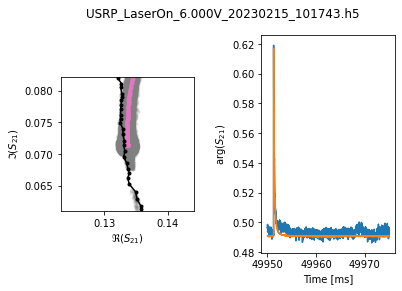

In [12]:
oft.get_all_average_pulse(LED_files, vna_file, p_params, bad_pls_idxs, extra_decimation=1, fraction_to_keep=0.5, window_shift_seconds=0, PHASE=True, save_shape=True, show_plots=True, verbose=False)